## Import Bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
import gensim 
from gensim.models import Word2Vec 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import du Dataset

In [2]:
data = pd.read_csv('DataSet.csv')

In [3]:
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## Répartition

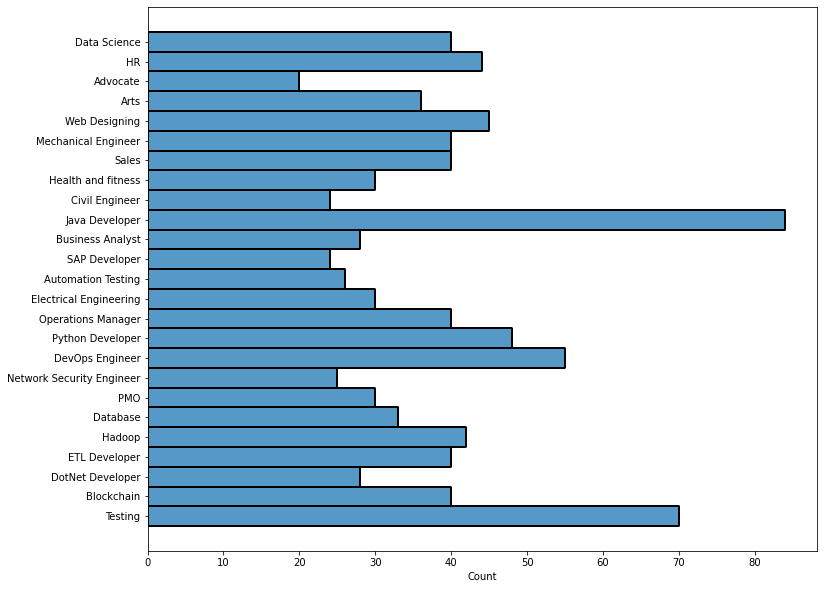

In [20]:
import seaborn as sns

#x = data['Category'].value_counts()
x = data['Category'].values
plt.figure(figsize=(12,10))
ax = sns.histplot(y=x)

## Nettoyage des données et prétraitement de texte

In [4]:
# Retourne une phrases sans les balises HTML, caractères spéciaux, met en miniscule et split :
def clean(x):
    soup = BeautifulSoup(x)
    text = soup.get_text()
    text = re.sub('[^a-zA-Z \n]', '', text)
    text = text.lower()
    new_text = text.split()
    return new_text

# Split un paragraphe, appel la fonction de "nettoyage", et retourne une liste de mots représentant notre paragraphe.
def preprocessing_text(x, tokenizer=tokenizer):
    text = tokenizer.tokenize(x)
    final_text = []
    for i, elem in enumerate(text):
        text[i] = clean(elem)
        for word in text[i]:
            final_text.append(word)
    return final_text

In [5]:
#On applique notre fonction à chaque ligne de note dataframe sur la colonne 'Resume' grâce à la fonction apply()
#et enregistre les résultats dans une nouvelle colonne
data['Preprocessing_Resume'] = data['Resume'].apply(preprocessing_text)

C:\Users\utilisateur\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [6]:
data.head()

,Category,Resume,Preprocessing_Resume
0,Data Science,Skills * Programming Languages: Python (pandas...,"[skills, programming, languages, python, panda..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,"[education, details, may, to, may, be, uitrgpv..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","[areas, of, interest, deep, learning, control,..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,"[skills, r, python, sap, hana, tableau, sap, h..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","[education, details, mca, ymcaust, faridabad, ..."


In [7]:
#Afin de former le modèle Word2Vec nous formons un array avec chacun de nos paragrahes prétraités.
sentences = []
data['Preprocessing_Resume'].map(lambda x: sentences.append(x))
sentences = np.array(sentences)

<ipython-input-7-d2dc98d5c89d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)


## Modèle Word2Vec

In [8]:
model = Word2Vec(sentences, sg=1, hs=1, sample=0.0001, size=300, window=10, workers=6, min_count=40)

## Calcul des moyennes vectorielles

In [9]:
#Transforme chaque mot en matrice et calcul la moyenne vectorielle pour un paragraphe.
def vector_mean(clean_review, model=model, nb_features=300):
    mean_matrix = np.zeros(nb_features)
    nb_matrix = 0
    for word in clean_review:
        try:
            mean_matrix += model.wv.get_vector(word)
            nb_matrix += 1
        except:
            continue
    
    return mean_matrix/nb_matrix

In [10]:
#On applique notre fonction à chaque ligne de note dataframe sur la colonne 'Preprocessing_Resume' grâce à la fonction 
# map() et enregistre les résultats dans une nouvelle colonne 'mean_matrix'
data['mean_matrix'] = data['Preprocessing_Resume'].map(vector_mean)

In [11]:
data.head()

,Category,Resume,Preprocessing_Resume,mean_matrix
0,Data Science,Skills * Programming Languages: Python (pandas...,"[skills, programming, languages, python, panda...","[-0.005811324146161058, 0.023537962210465627, ..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,"[education, details, may, to, may, be, uitrgpv...","[0.11386792402061605, 0.05171272284879359, -0...."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","[areas, of, interest, deep, learning, control,...","[0.03145796262265686, 0.08038898997810634, -0...."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,"[skills, r, python, sap, hana, tableau, sap, h...","[0.04400060253128243, 0.024941422286190642, -0..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","[education, details, mca, ymcaust, faridabad, ...","[0.10329148734919727, 0.08157018341124057, -0...."


## Définition des features et labels

In [12]:
from sklearn.preprocessing import LabelEncoder

X = []
data['mean_matrix'].map(lambda x: X.append(x))
X = np.array(X)

LabEnc = LabelEncoder()
y = data['Category'].values
y = LabEnc.fit_transform(y)

print(X.shape)
print(y.shape)

(962, 300)
(962,)


## Split des données en train et test / Entrainement et prediction Modèle RandomForestClassifier sur les données de train

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

In [15]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [16]:
predictions = clf.predict(X_test)

## Evaluation 

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

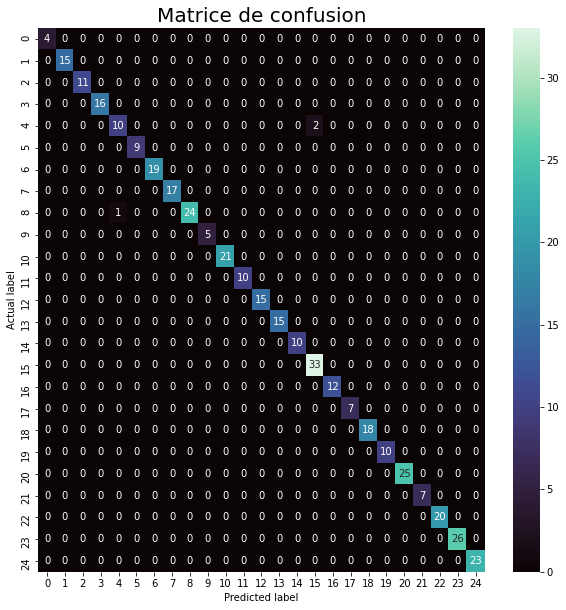

In [18]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size = 20)
plt.show()

In [19]:
accuracy = accuracy_score(y_test, predictions)

print(f'Notre modèle possède une précision de {accuracy} %')

0.9922077922077922

**Notre modèle à une précision de 99.2%**.

## Sac de centroïdes

Nous réexécutons les étapes précendantes avec la méthode du sac de centroïde afin de déterminer quelle méthodes obtient de meilleurs résultats. 

In [32]:
#Détermine notre nombre de culters
n_clusters = len(list(model.wv.vocab))//5

print('Nombre de Clusters : ', n_clusters)

Nombre de Clusters :  287


In [21]:
#Calcul la vecteur pour chaque mots présent dans le vocabulaire de notre modèle Word2Vec
matrix_words = model[model.wv.vocab]
matrix_words.shape

<ipython-input-21-839325a9e58a>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  matrix_words = model[model.wv.vocab]


(1436, 300)

In [22]:
#Création des clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit_predict(matrix_words)

array([22, 91, 91, ..., 38, 38, 88])

In [23]:
#Création d'un dictionnaire où chaque mot est affilié à son cluster
dic = {}

for word in list(model.wv.vocab):
    vector = model.wv.get_vector(word)
    vector = vector.reshape(1, vector.shape[0])
    cluster = kmeans.predict(vector)
    dic[word] = cluster[0]

dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}
dic

{'employee': 0,
 'employees': 0,
 'annual': 0,
 'customers': 1,
 'financial': 1,
 'departments': 1,
 'invoices': 1,
 'energy': 1,
 'four': 1,
 'general': 1,
 'banking': 1,
 'range': 1,
 'investment': 1,
 'provides': 1,
 'consultants': 1,
 'calls': 1,
 'emails': 1,
 'payments': 1,
 'secured': 2,
 'mumbai': 2,
 'internet': 2,
 'period': 2,
 'since': 2,
 'chennai': 2,
 'april': 2,
 'commerce': 2,
 'st': 2,
 'location': 2,
 'telecommunication': 2,
 'review': 3,
 'end': 3,
 'control': 3,
 'r': 3,
 'client': 3,
 'successfully': 3,
 'status': 3,
 'conference': 3,
 'preparation': 3,
 'lead': 3,
 'meetings': 3,
 'after': 3,
 'plant': 3,
 'weekly': 3,
 'co': 3,
 'controls': 3,
 'mac': 3,
 'oil': 3,
 'controller': 3,
 'package': 4,
 'maintaining': 4,
 'increase': 4,
 'according': 4,
 'architecture': 4,
 'configuring': 4,
 'modelling': 5,
 'this': 5,
 'based': 5,
 'used': 5,
 'detection': 5,
 'system': 5,
 'role': 5,
 'find': 5,
 'area': 5,
 'name': 5,
 'executed': 5,
 'real': 5,
 'validation': 5,

In [24]:
#Retourne un sac de centroïdes pour un paragraphe. 
def centroids_bag(review, dic=dic):
    #Pour un paragraphe, créer un dictionnaire avec l'effectifs de mots.
    dic_count = {}
    for word in review:
        if word in dic_count.keys():
            dic_count[word] += 1
        else:
            dic_count[word] = 1
    #print(dic_count)
    
    #Création du sac de centroids avec le dictionnaire d'éffectif.
    centroids_bag = np.zeros(n_clusters)
    for k, v in dic.items():
        if k in dic_count.keys():
            centroids_bag[v] += dic_count[k]
        else:
            centroids_bag[v] = 0
    
    return np.array(centroids_bag)

In [25]:
#On applique notre fonction à chaque ligne de note dataframe sur la colonne 'Preprocessing_Resume' grâce à la fonction 
# map()et enregistre les résultats dans une nouvelle colonne 'centroids_matrix'
data['centroids_matrix'] = data['Preprocessing_Resume'].map(centroids_bag)

In [26]:
data.head()

,Category,Resume,Preprocessing_Resume,mean_matrix,centroids_matrix
0,Data Science,Skills * Programming Languages: Python (pandas...,"[skills, programming, languages, python, panda...","[-0.005811324146161058, 0.023537962210465627, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,"[education, details, may, to, may, be, uitrgpv...","[0.11386792402061605, 0.05171272284879359, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","[areas, of, interest, deep, learning, control,...","[0.03145796262265686, 0.08038898997810634, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,"[skills, r, python, sap, hana, tableau, sap, h...","[0.04400060253128243, 0.024941422286190642, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","[education, details, mca, ymcaust, faridabad, ...","[0.10329148734919727, 0.08157018341124057, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Définition des features et labels

In [27]:
X_2 = []
data['centroids_matrix'].map(lambda x: X_2.append(x))
X_2 = np.array(X_2)

y_2 = data['Category'].values
LabEnc_2 = LabelEncoder()
y = LabEnc_2.fit_transform(y)

print(X_2.shape)
print(y_2.shape)

(962, 287)
(962,)


### Split des données en train et test / Entrainement et prediction Modèle RandomForestClassifier sur les données de train

In [28]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, shuffle=True)

clf_2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf_2.fit(X_train_2, y_train_2)

RandomForestClassifier(random_state=0)

In [29]:
predictions_2 = clf_2.predict(X_test_2)

### Evaluation

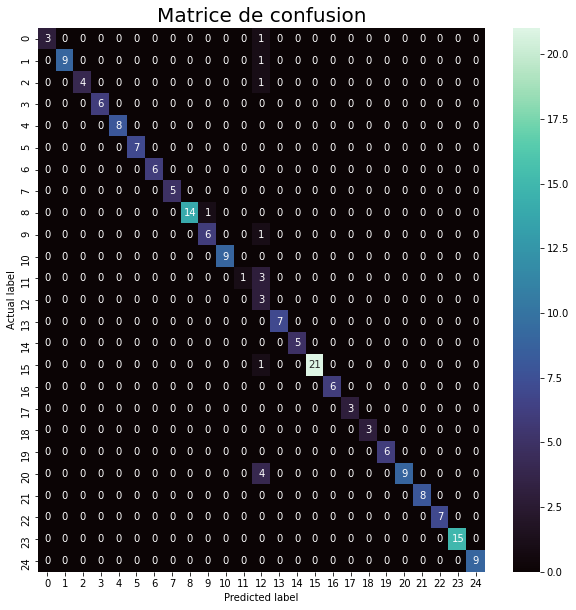

In [30]:
cm = confusion_matrix(y_test_2, predictions_2)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size = 20)
plt.show()

In [31]:
accuracy_2 = accuracy_score(y_test_2, predictions_2)

print(f'Notre modèle possède une précision de {accuracy_2} %')

0.9326424870466321

**Le modèle avec les sac de centroids obtient de moins bon résulat (93.2% de précision) que celui formé à partir des moyennes vectorielles de chaque CV (99.2%)**

Nous nous tournerons donc vers le modèle réalisé avec la méthode des moyennes vectorielles. Malheureusement, les résultats ne sont pas fiables. En effet, sur les 900 CV de notre dataset, seulement 160 sont unique. Le modèle doit donc être entrainé et testé avec un nouveau dataset.